In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
import eli5
import shap
from catboost import CatBoostRegressor
from urllib.request import urlopen
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.



# 데이터 살펴보기

In [4]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

## shape

In [301]:
train.shape, test.shape

((3000, 23), (4398, 22))

### shape로 알 수 있는 것
피처가 굉장히 많고, 테스트가 트레인보다 양이 많음.

## describe

In [3]:
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


In [8]:
test.describe()

,id,budget,popularity,runtime
count,4398.000000,4.398000e+03,4398.000000,4394.000000
mean,5199.500000,2.264929e+07,8.550230,107.622212
std,1269.737571,3.689991e+07,12.209014,21.058290
min,3001.000000,0.000000e+00,0.000001,0.000000
25%,4100.250000,0.000000e+00,3.895186,94.000000
50%,5199.500000,7.450000e+06,7.482241,104.000000
75%,6298.750000,2.800000e+07,10.938524,118.000000
max,7398.000000,2.600000e+08,547.488298,320.000000


### 해당 describe로 알 수 있는 것
1. id는 인덱스 대신이라 삭제해도 될듯
2. 결측치가 조금 있는 것 같으니 찍어보자
3. 수치형 피처가 별로 없음.(불안)

## Missing value

In [86]:
pd.DataFrame([train.isna().sum(), test.isna().sum()], index = ['Train', 'Test']).T

,Train,Test
id,0.0,0.0
belongs_to_collection,2396.0,3521.0
budget,0.0,0.0
genres,7.0,16.0
homepage,2054.0,2978.0
imdb_id,0.0,0.0
original_language,0.0,0.0
original_title,0.0,0.0
overview,8.0,14.0
popularity,0.0,0.0


In [93]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        # na면 거르고 값이 있으면  바꿔주기
        df[column] = df[column].apply(lambda x: None if pd.isna(x) else ast.literal_eval(x))
    return df

text_to_dict(train)
text_to_dict(test)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,None,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,None,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,None,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,None,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,/sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg,"[{'name': 'TS Productions', 'id': 313}, {'name...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,None,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,None,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,7394,None,42000000,"[{'id': 53, 'name': 'Thriller'}]",NaN,tt0218922,en,Original Sin,A young man is plunged into a life of subterfu...,9.970359,/i8FEQy5IWAqOzXm4uDHy2r3Swym.jpg,"[{'name': 'Intermedia Films', 'id': 763}, {'na...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",8/3/01,118.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,This is not a love story - it's a story about ...,Original Sin,"[{'id': 515, 'name': 'women'}, {'id': 572, 'na...","[{'cast_id': 17, 'character': 'Julia Russell/B...","[{'credit_id': '52fe4330c3a36847f80412db', 'de..."
4394,7395,"[{'id': 146534, 'name': 'Without a Paddle Coll...",19000000,"[{'id':

### Missing value로 알 수 있는 것
1. 너무 많아서 사용하기 어려운 피처들도 보이지만(belongs_to_collection, hompage...) 결측치가 많지 않은 것(cast, crew)들도 보이니 좀 다듬으면 사용할 수 있는 것들도 보임.
2. 일단 ID를 제외해도 될 거 같음.

# 피처들 하나씩 탐색하기

## belong_to_collection

### 바이너리로 유무 적자

In [319]:
# belong to colleciton 유무
pd.DataFrame([~train.belongs_to_collection.isna(), train.revenue]).T.corr()

,belongs_to_collection,revenue
belongs_to_collection,1.000000,0.339425
revenue,0.339425,1.000000


In [95]:
train.belongs_to_collection.isna().sum()

2396

In [20]:
for i in train.belongs_to_collection[:5]:
    print(i)

[{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
[{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
{}
{}
{}


### 혹시 id, name, poster_path 말고 다른 것도 있는지 보자.

In [300]:
show_another = train.belongs_to_collection[train.belongs_to_collection != {}]\
                .apply(lambda x: list(x[0].keys() if x[0] != {} else {}))
show_another

TypeError: 'NoneType' object is not subscriptable

In [52]:
show_another_value = sum(show_another, [])
set(show_another_value)

{'backdrop_path', 'id', 'name', 'poster_path'}

### 이 컬럼이 결측치도 엄청 많은데 써야 하나 생각이 듦.

In [67]:
# poster랑 backdrop path는 포스터 이미지인 거 같고, name은 title이랑 겹칠 거 같은데 보자.
for i in train[["belongs_to_collection", "title"]].values[:20]:
    if {} not in i:
        print(i[0][0]['name'], "//", i[1])

Hot Tub Time Machine Collection // Hot Tub Time Machine 2
The Princess Diaries Collection // The Princess Diaries 2: Royal Engagement
The Muppet Collection // Muppet Treasure Island
Rocky Collection // Rocky
Revenge of the Nerds Collection // Revenge of the Nerds II: Nerds in Paradise
Chili Palmer Collection // Be Cool
The Transporter Collection // Transporter 2


### belongs_to_collection은 버려도 되겠다는 생각이 듦.

## budget

In [96]:
train.budget.isna().sum()

0

In [98]:
train.budget.describe()

count    3.000000e+03
mean     2.253133e+07
std      3.702609e+07
min      0.000000e+00
25%      0.000000e+00
50%      8.000000e+06
75%      2.900000e+07
max      3.800000e+08
Name: budget, dtype: float64

### 예산이 0으로 적힌 건 뭘까?

In [104]:
train[train.budget == 0][:1]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
4,5,None,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.14807,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,None,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,None,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


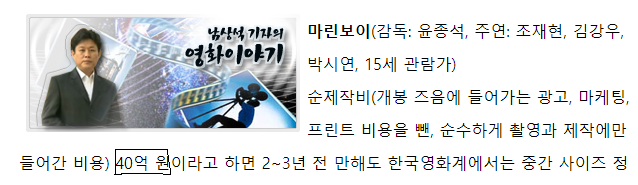

### 예산 0원은  결측치로 봐야 될 거 같다.

0의 값이 얼마나 많은지 보자.

In [105]:
(train.budget == 0).sum()

812

### 영화의 인기와 제작비가 무조건 비례하지는 않지만 분명히 제작비가 많이 들어가면 배우들 라인업부터 다를 텐데, 분명히 인기와 어느 정도 비례하는 지표지만 결측치가 많다.

## genres

In [110]:
train.genres.isna().sum()

7

### 결측치가 이 정도면 채워넣어도 될 거 같다.

In [109]:
for i in train.genres[:5]:
    print(i)

[{'id': 35, 'name': 'Comedy'}]
[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
[{'id': 18, 'name': 'Drama'}]
[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
[{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


### 장르가 여러 개인 것도 있으니 전체 장르 분포를 보자.

In [172]:
train_genres = []
for i in train.genres:
    dummy = []
    if i != None:
        for j in i:
            dummy.append(j['name'])
        train_genres.append(dummy)
#     else:
#         train_genres.append(None)
    

In [173]:
Counter(sum(train_genres, [])).most_common()

[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100),
 ('War', 100),
 ('Documentary', 87),
 ('Western', 43),
 ('Foreign', 31),
 ('TV Movie', 1)]

### 장르가 몇 개로 이루어져 있는지?

In [174]:
Counter([len(i) for i in train_genres]).most_common()

[(2, 972), (3, 900), (1, 593), (4, 393), (5, 111), (6, 21), (7, 3)]

### 해당 컬럼은 빈 거 처리하는 거 잊지 말고, 장르들을 원핫벡터로 표현해서 피처를 만들어줘서 인풋으로 넣어도 될 거 같음.

## homepage

### 바이너리로 유무 해주기

In [324]:
pd.DataFrame([~train.homepage.isna(), train.revenue]).T.corr()

,homepage,revenue
homepage,1.000000,0.263179
revenue,0.263179,1.000000


In [178]:
train.homepage.head()

0                                  NaN
1                                  NaN
2    http://sonyclassics.com/whiplash/
3           http://kahaanithefilm.com/
4                                  NaN
Name: homepage, dtype: object

### 안 써도 되는 컬럼인듯

## imdb_id

In [180]:
train.imdb_id.isna().sum()

0

In [181]:
train.imdb_id.head()

0    tt2637294
1    tt0368933
2    tt2582802
3    tt1821480
4    tt1380152
Name: imdb_id, dtype: object

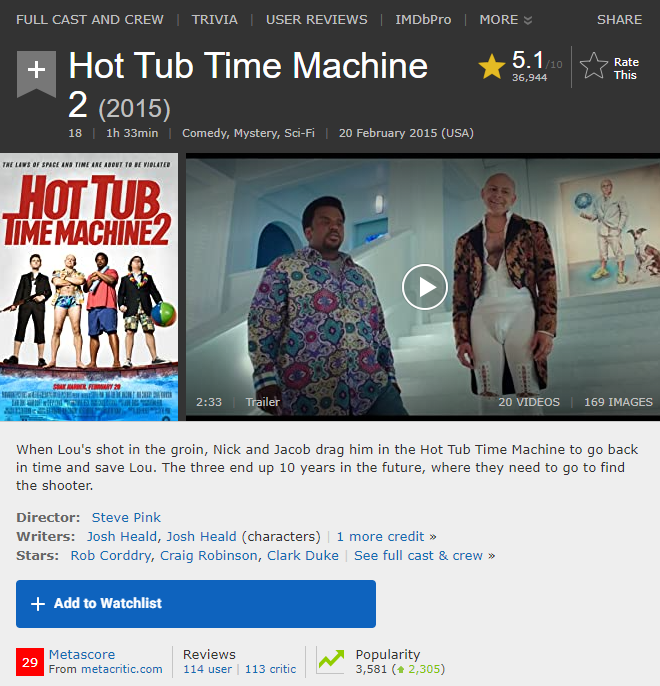

### 평점을 몇 명이나 메겼고, 평점이 몇 점인지 크롤링해서 피처를 추가하면 트레인할 때는 엄청 도움이 되는 피처겠지만 test에는 적용할 수 없으니 이 컬럼도 거르자 

## original_language

In [184]:
train.original_language.isna().sum()

0

In [182]:
train.original_language

0       en
1       en
2       en
3       hi
4       ko
        ..
2995    en
2996    sv
2997    en
2998    en
2999    en
Name: original_language, Length: 3000, dtype: object

### unique

In [187]:
train.original_language.unique(), len(train.original_language.unique())

(array(['en', 'hi', 'ko', 'sr', 'fr', 'it', 'nl', 'zh', 'es', 'cs', 'ta',
        'cn', 'ru', 'tr', 'ja', 'fa', 'sv', 'de', 'te', 'pt', 'mr', 'da',
        'fi', 'el', 'ur', 'he', 'no', 'ar', 'nb', 'ro', 'vi', 'pl', 'hu',
        'ml', 'bn', 'id'], dtype=object),
 36)

## Counter

In [190]:
Counter(train.original_language).most_common()

[('en', 2575),
 ('fr', 78),
 ('ru', 47),
 ('es', 43),
 ('hi', 42),
 ('ja', 37),
 ('it', 24),
 ('ko', 20),
 ('cn', 20),
 ('zh', 19),
 ('de', 18),
 ('ta', 16),
 ('sv', 8),
 ('nl', 6),
 ('pt', 6),
 ('fa', 5),
 ('da', 5),
 ('ro', 4),
 ('tr', 3),
 ('hu', 3),
 ('te', 2),
 ('fi', 2),
 ('no', 2),
 ('pl', 2),
 ('ml', 2),
 ('sr', 1),
 ('cs', 1),
 ('mr', 1),
 ('el', 1),
 ('ur', 1),
 ('he', 1),
 ('ar', 1),
 ('nb', 1),
 ('vi', 1),
 ('bn', 1),
 ('id', 1)]

### 대중적으로 주로 쓰이는 영어가 아니면 첫 오픈한 국가에서 인기가 있더라도 끌기 어려울 수 있음, 한국에서 영미권 영화가 동시개봉한다거나 하는 사례는 많지만 다른 국가는 거의 없다고 생각함.<br>있더라도 거의 드묾, 반면 영미권에서 제작된 영화는 재미가 있든 없든 기대가 되면 어느 국가든 자막으로 동시오픈돼서 수익이 어느 정도 뻥튀기가 될 수 있다고 생각하지만 이 모든 걸 고려해서 모델에 넣으려면 쉽지 않을 것 같아서 일단 해당 피처를 사용하는 건 보류

## original_title

In [192]:
train.original_title.isna().sum()

0

In [193]:
train.original_title.head()

0                      Hot Tub Time Machine 2
1    The Princess Diaries 2: Royal Engagement
2                                    Whiplash
3                                     Kahaani
4                                        마린보이
Name: original_title, dtype: object

### 영화제목이랑 인기는 큰 상관관계가 없을 것 같고, 있더라도 간단하게 상관관계를 찾을 수 있을 것 같지 않음.

## overview

In [194]:
train.overview.isna().sum()

8

In [195]:
train.overview.head()

0    When Lou, who has become the "father of the In...
1    Mia Thermopolis is now a college graduate and ...
2    Under the direction of a ruthless instructor, ...
3    Vidya Bagchi (Vidya Balan) arrives in Kolkata ...
4    Marine Boy is the story of a former national s...
Name: overview, dtype: object

### 위와 마찬가지

## popularity

In [196]:
train.popularity.isna().sum()

0

In [197]:
train.popularity.head()

0     6.575393
1     8.248895
2    64.299990
3     3.174936
4     1.148070
Name: popularity, dtype: float64

### 아마 타겟이랑 상관관계가 높은 컬럼 중 하나일 거 같은데, 확인해보자

In [199]:
train.corr()

,id,budget,popularity,runtime,revenue
id,1.000000,0.019732,-0.007470,0.010750,0.000610
budget,0.019732,1.000000,0.342356,0.238373,0.752965
popularity,-0.007470,0.342356,1.000000,0.133690,0.461460
runtime,0.010750,0.238373,0.133690,1.000000,0.216380
revenue,0.000610,0.752965,0.461460,0.216380,1.000000


### budget과 차이가 좀 있긴 하지만 상당히 높은 상관관계임.

## poster_path

In [200]:
train.poster_path.isna().sum()

1

In [202]:
train.poster_path.head()

0    /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg
1    /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg
2    /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg
3    /aTXRaPrWSinhcmCrcfJK17urp3F.jpg
4    /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg
Name: poster_path, dtype: object

### 삭제하자

## production_companies

In [204]:
train.production_companies.isna().sum()

156

In [206]:
for i in train.production_companies.head():
    print(i)

[{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
[{'name': 'Walt Disney Pictures', 'id': 2}]
[{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
None
None


### 전체 회사가 몇 개 있는지

In [207]:
train_production_companies = []
for i in train.production_companies:
    dummy = []
    if i != None:
        for j in i:
            dummy.append(j['name'])
        train_production_companies.append(dummy)
#     else:
#         train_production_companies.append(None)


In [211]:
Counter(sum(train_production_companies, [])).most_common()

[('Warner Bros.', 202),
 ('Universal Pictures', 188),
 ('Paramount Pictures', 161),
 ('Twentieth Century Fox Film Corporation', 138),
 ('Columbia Pictures', 91),
 ('Metro-Goldwyn-Mayer (MGM)', 84),
 ('New Line Cinema', 75),
 ('Touchstone Pictures', 63),
 ('Walt Disney Pictures', 62),
 ('Columbia Pictures Corporation', 61),
 ('TriStar Pictures', 53),
 ('Relativity Media', 48),
 ('Canal+', 46),
 ('United Artists', 44),
 ('Miramax Films', 40),
 ('Village Roadshow Pictures', 36),
 ('Regency Enterprises', 31),
 ('BBC Films', 30),
 ('Dune Entertainment', 30),
 ('Working Title Films', 30),
 ('Fox Searchlight Pictures', 29),
 ('StudioCanal', 28),
 ('Lionsgate', 28),
 ('DreamWorks SKG', 27),
 ('Fox 2000 Pictures', 25),
 ('Summit Entertainment', 24),
 ('Hollywood Pictures', 24),
 ('Orion Pictures', 24),
 ('Amblin Entertainment', 23),
 ('Dimension Films', 23),
 ('Castle Rock Entertainment', 21),
 ('Epsilon Motion Pictures', 21),
 ('Morgan Creek Productions', 21),
 ('Original Film', 21),
 ('Focus 

### 로우별 회사가 몇 개로 이루어져 있는지

In [212]:
Counter([len(i) for i in train_production_companies]).most_common()

[(1, 775),
 (2, 734),
 (3, 582),
 (4, 312),
 (5, 166),
 (6, 118),
 (7, 62),
 (8, 42),
 (9, 29),
 (10, 7),
 (11, 7),
 (12, 3),
 (15, 2),
 (16, 2),
 (13, 1),
 (14, 1),
 (17, 1)]

### 이 컬럼도 원핫인코딩해서 넣어볼만한듯

## production_countries

In [214]:
train.production_countries.isna().sum()

55

In [222]:
for i in train.production_countries.head(7):
    print(i)

[{'iso_3166_1': 'US', 'name': 'United States of America'}]
[{'iso_3166_1': 'US', 'name': 'United States of America'}]
[{'iso_3166_1': 'US', 'name': 'United States of America'}]
[{'iso_3166_1': 'IN', 'name': 'India'}]
[{'iso_3166_1': 'KR', 'name': 'South Korea'}]
None
[{'iso_3166_1': 'US', 'name': 'United States of America'}, {'iso_3166_1': 'CA', 'name': 'Canada'}]


### 전체 제작 국가가 몇 개인지

In [217]:
train_production_countries = []
for i in train.production_countries:
    dummy = []
    if i != None:
        for j in i:
            dummy.append(j['iso_3166_1'])
        train_production_countries.append(dummy)
#     else:
#         train_production_countries.append(None)


In [218]:
Counter(sum(train_production_countries, [])).most_common()

[('US', 2282),
 ('GB', 380),
 ('FR', 222),
 ('DE', 167),
 ('CA', 120),
 ('IN', 81),
 ('IT', 64),
 ('JP', 61),
 ('AU', 61),
 ('RU', 58),
 ('ES', 54),
 ('CN', 42),
 ('HK', 42),
 ('IE', 23),
 ('BE', 23),
 ('KR', 22),
 ('MX', 19),
 ('SE', 18),
 ('NZ', 17),
 ('NL', 15),
 ('CZ', 14),
 ('DK', 13),
 ('BR', 12),
 ('LU', 10),
 ('ZA', 10),
 ('HU', 9),
 ('AE', 9),
 ('AT', 8),
 ('CH', 8),
 ('RO', 8),
 ('GR', 7),
 ('NO', 7),
 ('AR', 6),
 ('CL', 6),
 ('FI', 6),
 ('IL', 5),
 ('TR', 5),
 ('IR', 5),
 ('PL', 5),
 ('MA', 3),
 ('PH', 3),
 ('TW', 3),
 ('BG', 3),
 ('BS', 3),
 ('RS', 2),
 ('IS', 2),
 ('KH', 2),
 ('MT', 2),
 ('PK', 2),
 ('QA', 2),
 ('TN', 2),
 ('UA', 2),
 ('SG', 2),
 ('ID', 2),
 ('PE', 1),
 ('MN', 1),
 ('PR', 1),
 ('NA', 1),
 ('BA', 1),
 ('CS', 1),
 ('DZ', 1),
 ('ET', 1),
 ('PT', 1),
 ('SI', 1),
 ('SA', 1),
 ('JO', 1),
 ('HR', 1),
 ('CY', 1),
 ('UY', 1),
 ('PY', 1),
 ('MR', 1),
 ('CR', 1),
 ('BF', 1),
 ('GH', 1)]

In [219]:
Counter([len(i) for i in train_production_countries]).most_common()

[(1, 2222), (2, 525), (3, 116), (4, 57), (5, 21), (6, 3), (8, 1)]

### 다른 나라와 협업을 맺은 것도 타겟에 영향을 미칠 수 있음.

## release_date

In [242]:
train.release_date.isna().sum()

0

In [244]:
train.release_date.head()

0     2/20/15
1      8/6/04
2    10/10/14
3      3/9/12
4      2/5/09
Name: release_date, dtype: object

### 년, 월까지는 사용해도 괜찮을 거 같고, 과거에도 이런 코로나 같은 역병이 창궐했을 때가 있다면 매출이 떨어졌을듯... 고려할만한 요소임

## runtime

In [245]:
train.runtime.isna().sum()

2

In [246]:
train.runtime.head()

0     93.0
1    113.0
2    105.0
3    122.0
4    118.0
Name: runtime, dtype: float64

In [249]:
train.corr()

,id,budget,popularity,runtime,revenue
id,1.000000,0.019732,-0.007470,0.010750,0.000610
budget,0.019732,1.000000,0.342356,0.238373,0.752965
popularity,-0.007470,0.342356,1.000000,0.133690,0.461460
runtime,0.010750,0.238373,0.133690,1.000000,0.216380
revenue,0.000610,0.752965,0.461460,0.216380,1.000000


### 제작비와 어느 정도 비례할 수도 있겠지만 매출과도 상당히 상관관계가 높음. 넣자.

## spoken_languages

In [251]:
train.spoken_languages.isna().sum()

20

In [252]:
train.spoken_languages.head()

0             [{'iso_639_1': 'en', 'name': 'English'}]
1             [{'iso_639_1': 'en', 'name': 'English'}]
2             [{'iso_639_1': 'en', 'name': 'English'}]
3    [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
4             [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]
Name: spoken_languages, dtype: object

### 전체 언어

In [254]:
train_spoken_languages = []
for i in train.spoken_languages:
    dummy = []
    if i != None:
        for j in i:
            dummy.append(j['iso_639_1'])
        train_spoken_languages.append(dummy)
#     else:
#         train_spoken_languages.append(None)

In [255]:
Counter(sum(train_spoken_languages, [])).most_common()

[('en', 2618),
 ('fr', 288),
 ('es', 239),
 ('de', 169),
 ('ru', 152),
 ('it', 124),
 ('ja', 89),
 ('zh', 68),
 ('hi', 56),
 ('pt', 43),
 ('ar', 40),
 ('ko', 37),
 ('cn', 36),
 ('ta', 27),
 ('pl', 25),
 ('hu', 24),
 ('la', 23),
 ('sv', 22),
 ('th', 22),
 ('cs', 20),
 ('he', 15),
 ('el', 15),
 ('tr', 13),
 ('da', 13),
 ('nl', 10),
 ('fa', 10),
 ('vi', 10),
 ('yi', 8),
 ('ur', 8),
 ('ro', 8),
 ('te', 7),
 ('sw', 7),
 ('no', 7),
 ('xx', 7),
 ('fi', 6),
 ('uk', 6),
 ('gd', 5),
 ('tl', 5),
 ('sr', 4),
 ('af', 4),
 ('ml', 4),
 ('ga', 3),
 ('ca', 3),
 ('bn', 3),
 ('hy', 3),
 ('pa', 3),
 ('so', 3),
 ('is', 3),
 ('bg', 2),
 ('mr', 2),
 ('bo', 2),
 ('sq', 2),
 ('id', 2),
 ('sk', 2),
 ('eo', 2),
 ('eu', 2),
 ('zu', 2),
 ('mi', 2),
 ('hr', 2),
 ('qu', 1),
 ('kk', 1),
 ('sh', 1),
 ('ln', 1),
 ('my', 1),
 ('am', 1),
 ('sa', 1),
 ('ny', 1),
 ('st', 1),
 ('xh', 1),
 ('lo', 1),
 ('wo', 1),
 ('et', 1),
 ('ps', 1),
 ('si', 1),
 ('kw', 1),
 ('nv', 1),
 ('gu', 1),
 ('ku', 1),
 ('km', 1)]

### 로우당 사용된 언어

In [257]:
Counter([len(i) for i in train_spoken_languages]).most_common()

[(1, 2105),
 (2, 549),
 (3, 216),
 (4, 72),
 (5, 23),
 (7, 6),
 (6, 6),
 (8, 2),
 (9, 1)]

### 상관관계 찍어봐야 알듯, 제작 국가랑 original_language랑 비슷할듯, 너무 불균형

## status

In [259]:
train.status.isna().sum()

0

In [260]:
train.status.head()

0    Released
1    Released
2    Released
3    Released
4    Released
Name: status, dtype: object

In [262]:
train.status.value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

### 무엇을 의미하는 피처인지는 모르겠지만 사용 안 해도 될듯

## tagline

In [266]:
train.tagline.isna().sum()

597

In [269]:
train.tagline.head()

0    The Laws of Space and Time are About to be Vio...
1    It can take a lifetime to find true love; she'...
2      The road to greatness can take you to the edge.
3                                                  NaN
4                                                  NaN
Name: tagline, dtype: object

### 삭제

## title

In [272]:
train.title.isna().sum()

0

In [273]:
train.title

0                         Hot Tub Time Machine 2
1       The Princess Diaries 2: Royal Engagement
2                                       Whiplash
3                                        Kahaani
4                                     Marine Boy
                          ...                   
2995                                     Chasers
2996                            We Are the Best!
2997                     The Long Kiss Goodnight
2998                            Along Came Polly
2999                                   Abduction
Name: title, Length: 3000, dtype: object

### 1편보다 나은 2편은 없다고 하지만 제목에 2, 3이 들어가면 전작품이 인기가 많아서 나온 거니까 활용할 수 있을 거 같음

## keywords

In [277]:
train.Keywords.isna().sum()

276

In [278]:
train.Keywords.head()

0    [{'id': 4379, 'name': 'time travel'}, {'id': 9...
1    [{'id': 2505, 'name': 'coronation'}, {'id': 42...
2    [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...
3    [{'id': 10092, 'name': 'mystery'}, {'id': 1054...
4                                                 None
Name: Keywords, dtype: object

In [279]:
train_Keywords = []
for i in train.Keywords:
    dummy = []
    if i != None:
        for j in i:
            dummy.append(j['name'])
        train_Keywords.append(dummy)
#     else:
#         train_Keywords.append(None)
Counter(sum(train_Keywords, [])).most_common()

[('woman director', 175),
 ('independent film', 155),
 ('duringcreditsstinger', 134),
 ('murder', 123),
 ('based on novel', 111),
 ('violence', 87),
 ('sport', 82),
 ('biography', 77),
 ('aftercreditsstinger', 75),
 ('dystopia', 73),
 ('revenge', 73),
 ('friendship', 72),
 ('sex', 71),
 ('suspense', 67),
 ('sequel', 66),
 ('love', 64),
 ('police', 64),
 ('teenager', 61),
 ('nudity', 57),
 ('female nudity', 53),
 ('drug', 52),
 ('prison', 50),
 ('musical', 49),
 ('high school', 49),
 ('los angeles', 48),
 ('new york', 47),
 ('family', 45),
 ('father son relationship', 44),
 ('kidnapping', 41),
 ('investigation', 41),
 ('wedding', 40),
 ('3d', 40),
 ('detective', 38),
 ('london england', 38),
 ('paris', 37),
 ('based on comic', 37),
 ('robbery', 36),
 ('based on true story', 35),
 ('dying and death', 34),
 ('escape', 34),
 ('alien', 34),
 ('brother brother relationship', 34),
 ('prostitute', 34),
 ('suicide', 33),
 ('rape', 33),
 ('corruption', 33),
 ('death', 32),
 ('superhero', 32),
 (

In [280]:
Counter([len(i) for i in train_Keywords]).most_common()

[(5, 293),
 (4, 248),
 (3, 228),
 (6, 227),
 (2, 207),
 (7, 192),
 (1, 187),
 (8, 161),
 (9, 134),
 (11, 132),
 (10, 125),
 (12, 100),
 (13, 85),
 (15, 59),
 (14, 59),
 (16, 58),
 (17, 45),
 (18, 29),
 (20, 24),
 (21, 23),
 (19, 22),
 (22, 17),
 (23, 15),
 (24, 12),
 (27, 12),
 (25, 6),
 (26, 5),
 (37, 2),
 (28, 2),
 (32, 2),
 (31, 2),
 (30, 2),
 (29, 2),
 (33, 1),
 (39, 1),
 (40, 1),
 (38, 1),
 (149, 1),
 (43, 1),
 (97, 1)]

### 이 컬럼도 원핫인코딩해서 쓸 수 있을 거 같음.

## cast

In [281]:
train.cast.isna().sum()

13

In [289]:
for i in train.cast.head(1)[0][:5]:
    print(i)

{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}
{'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}
{'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}
{'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}
{'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}


In [291]:
train_cast = []
for i in train.cast:
    dummy = []
    if i != None:
        for j in i:
            dummy.append(j['name'])
        train_cast.append(dummy)
#     else:
#         train_cast.append(None)
Counter(sum(train_cast, [])).most_common()

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21),
 ('Jason Statham', 21),
 ('Keith David', 21),
 ('John Goodman', 21),
 ('Mel Gibson', 21),
 ('Sigourney Weaver', 21),
 ('Frank Welker', 20),
 ('Michael Caine', 20),
 ('George Clooney', 20),
 ('Denzel Washington', 20),
 ('Robert Duvall', 20),
 ('Ed Harris', 20),
 ('Dennis Quaid', 20),
 ('Richard Jenkins', 20),
 ('Matt Damon', 20),
 ('Christopher Plummer', 19),
 ('Gene Hackman', 19),
 ('Christopher Walken', 19),
 ('William H. Macy', 19),
 ('James Franco', 19),
 ('Jim Broadbent', 19),
 ('John C. Reilly', 19),
 ('Kevin Bacon', 19),
 ('Christian Bale', 19),
 ('Alec Baldwin', 19),
 ('Allison Janney', 18),
 ('Brian Cox', 18),
 ('John Leg

In [294]:
Counter([len(i) for i in train_cast]).most_common()

[(15, 212),
 (16, 165),
 (10, 135),
 (13, 129),
 (12, 124),
 (11, 122),
 (17, 118),
 (9, 118),
 (18, 115),
 (14, 110),
 (8, 106),
 (19, 102),
 (7, 96),
 (20, 93),
 (22, 77),
 (6, 76),
 (23, 71),
 (21, 68),
 (24, 57),
 (5, 57),
 (4, 52),
 (25, 50),
 (27, 44),
 (29, 42),
 (26, 39),
 (31, 37),
 (30, 32),
 (28, 30),
 (32, 26),
 (38, 25),
 (3, 23),
 (34, 22),
 (36, 21),
 (35, 20),
 (33, 19),
 (1, 16),
 (41, 15),
 (45, 14),
 (40, 13),
 (42, 13),
 (0, 13),
 (44, 12),
 (47, 12),
 (52, 11),
 (43, 10),
 (49, 10),
 (58, 10),
 (51, 9),
 (37, 9),
 (55, 9),
 (46, 9),
 (54, 9),
 (56, 8),
 (2, 8),
 (53, 8),
 (48, 7),
 (60, 7),
 (50, 6),
 (63, 6),
 (59, 5),
 (61, 5),
 (39, 5),
 (72, 5),
 (66, 5),
 (67, 4),
 (70, 4),
 (57, 4),
 (79, 3),
 (71, 3),
 (62, 3),
 (74, 3),
 (73, 3),
 (78, 3),
 (96, 3),
 (68, 3),
 (114, 3),
 (65, 3),
 (110, 3),
 (77, 2),
 (76, 2),
 (125, 2),
 (105, 2),
 (80, 2),
 (69, 2),
 (117, 2),
 (75, 2),
 (98, 2),
 (108, 1),
 (87, 1),
 (122, 1),
 (156, 1),
 (112, 1),
 (113, 1),
 (82, 1),
 

### 보증된 배우도 있을 수 있고, 참여 인원도 다 중요해보임.

## crew

In [295]:
train.crew.isna().sum()

16

In [297]:
for i in train.crew.head()[0][:5]:
    print(i)

{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}
{'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}
{'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}
{'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}
{'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}


### 파트랑 잡 둘 다 따야함. 프로필패스도 따서 이력 나오는 거면 확인해보면 좋을듯

## revenue

In [298]:
train.revenue.isna().sum()

0

In [299]:
train.revenue.head()

0    12314651
1    95149435
2    13092000
3    16000000
4     3923970
Name: revenue, dtype: int64

### 가장 중요한 피처